In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import yfinance as yf
import sys
from datetime import datetime
sys.path.append('../data_func')

from data_helper_functions import create_study_periods

In [2]:
df=pd.read_csv('../data/crsp_ff_adjusted.csv)
df.drop(columns=['Unnamed: 0'],inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.dropna(subset=['RET'],inplace=True)

In [ ]:
#select returns to use
#select returns to use
returns='RET'
df=df[['date','TICKER',f'{returns}']]
if returns!='RET':
    #rename returns column
    df.rename(columns={f'{returns}':'RET'},inplace=True)

In [3]:
study_periods=create_study_periods(df,n_periods=23,window_size=240,trade_size=250,train_size=750,forward_roll=250,start_date=datetime(1990,1,1),end_date=datetime(2015,12,31))

  0%|          | 0/38 [00:00<?, ?it/s]

 89%|████████▉ | 34/38 [00:05<00:00,  5.82it/s]

Reached the end of the dataset.


## Cross Sectional Median Model

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
from tqdm import tqdm
import numpy as np

# Calculate class weights

clf = RandomForestClassifier(n_estimators=1000, max_depth=20, random_state=42)

In [11]:
# Creating separate DataFrames for in-sample and out-of-sample portfolios
in_sample_long_portfolios = pd.DataFrame()
out_of_sample_long_portfolios = pd.DataFrame()

in_sample_short_portfolios = pd.DataFrame()
out_of_sample_short_portfolios = pd.DataFrame()

# Assuming study_periods contains the train-test split dataframes
for train_df, test_df in tqdm(study_periods):
    X_train = train_df[['standardized_return']]
    y_train = train_df['target'].replace({0: 0, 1: 1}).astype(int)

    X_test = test_df[['standardized_return']]
    y_test = test_df['target'].replace({0: 0, 1: 1}).astype(int)
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = {0: class_weights[0], 1: class_weights[1] * 5}  # Increase the weight for class 1 as needed

    clf = RandomForestClassifier(n_estimators=1000, max_depth=20, random_state=42, class_weight=class_weights_dict)

    # Train the classifier
    clf.fit(X_train, y_train)

    # Predict on both train and test data
    train_probs = clf.predict_proba(X_train)[:, 1]
    test_probs = clf.predict_proba(X_test)[:, 1]

    # Assign predicted probabilities back to train and test dataframes
    train_df['predicted_prob'] = train_probs
    test_df['predicted_prob'] = test_probs

    k = 10

    # Iterate over unique dates in train_df for in-sample data
    for date in train_df['date'].unique():
        date_data = train_df[train_df['date'] == date]
        sorted_data = date_data.sort_values(by='predicted_prob', ascending=False)

        long_tickers = sorted_data.head(k)[['date', 'TICKER', 'predicted_prob']]
        short_tickers = sorted_data.tail(k)[['date', 'TICKER', 'predicted_prob']]

        in_sample_long_portfolios = pd.concat([in_sample_long_portfolios, long_tickers])
        in_sample_short_portfolios = pd.concat([in_sample_short_portfolios, short_tickers])

    # Iterate over unique dates in test_df for out-of-sample data
    for date in test_df['date'].unique():
        date_data = test_df[test_df['date'] == date]
        sorted_data = date_data.sort_values(by='predicted_prob', ascending=False)

        long_tickers = sorted_data.head(k)[['date', 'TICKER', 'predicted_prob']]
        short_tickers = sorted_data.tail(k)[['date', 'TICKER', 'predicted_prob']]

        out_of_sample_long_portfolios = pd.concat([out_of_sample_long_portfolios, long_tickers])
        out_of_sample_short_portfolios = pd.concat([out_of_sample_short_portfolios, short_tickers])


100%|██████████| 34/34 [1:13:25<00:00, 129.57s/it]


# Portfolios

In [12]:
returns_df=df[['date','TICKER','RET']]

In [1]:
#pickle the porfolios and returns df
in_sample_long_portfolios.to_pickle('../data/rf_results/in_sample_long_portfolios.pkl')
in_sample_short_portfolios.to_pickle('../data/rf_results/in_sample_short_portfolios.pkl')
out_of_sample_long_portfolios.to_pickle('../data/rf_results/out_of_sample_long_portfolios.pkl')
out_of_sample_short_portfolios.to_pickle('../data/rf_results/out_of_sample_short_portfolios.pkl')
returns_df.to_pickle('../data/rf_results/returns_df.pkl')


NameError: name 'in_sample_long_portfolios' is not defined

In [13]:
# ... (assuming other necessary imports are done above)
from math import sqrt

# Function to calculate portfolio returns
def calculate_portfolio_returns(portfolios, returns_df):
    merged_df = portfolios.merge(returns_df, on=['date', 'TICKER'])
    
    # Debugging print to check the merged DataFrame
    print(merged_df.head())
    
    portfolio_returns = merged_df['RET'].groupby(merged_df['date']).sum()
    
    # Debugging print to check the portfolio returns
    print(portfolio_returns.head())
    
    return portfolio_returns


# Function to calculate Sharpe ratio
def calculate_sharpe_ratio(returns, rf=0.0004):
    expected_return = returns.mean()
    std_dev = returns.std()
    sharpe_ratio = (expected_return - rf) / std_dev if std_dev != 0 else 0  # Added a condition to avoid division by zero
    return sharpe_ratio

def calculate_annualized_sharpe_ratio(sharpe_ratio, periods_per_year=252):
    annualized_sharpe_ratio = sharpe_ratio * sqrt(periods_per_year)
    return annualized_sharpe_ratio


# Calculate in-sample and out-of-sample returns for long and short portfolios
in_sample_long_returns = calculate_portfolio_returns(in_sample_long_portfolios, returns_df)
out_of_sample_long_returns = calculate_portfolio_returns(out_of_sample_long_portfolios, returns_df)

in_sample_short_returns = -calculate_portfolio_returns(in_sample_short_portfolios, returns_df)
out_of_sample_short_returns = -calculate_portfolio_returns(out_of_sample_short_portfolios, returns_df)

# Calculate total returns (long + short)
in_sample_total_returns = in_sample_long_returns + in_sample_short_returns
out_of_sample_total_returns = out_of_sample_long_returns + out_of_sample_short_returns

# Calculate Sharpe ratios
in_sample_sharpe = calculate_sharpe_ratio(in_sample_total_returns)
out_of_sample_sharpe = calculate_sharpe_ratio(out_of_sample_total_returns)



# Calculate annualized Sharpe ratios
in_sample_annualized_sharpe = calculate_annualized_sharpe_ratio(in_sample_sharpe)
out_of_sample_annualized_sharpe = calculate_annualized_sharpe_ratio(out_of_sample_sharpe)
print(f"In-Sample Annualized Sharpe Ratio: {in_sample_annualized_sharpe}")
print(f"Out-Of-Sample Annualized Sharpe Ratio: {out_of_sample_annualized_sharpe}")


        date TICKER  predicted_prob       RET
0 1990-02-01   SUNW             1.0  0.012903
1 1990-02-01    LTD             1.0  0.045627
2 1990-02-01    PBI             1.0  0.005780
3 1990-02-01    CYR             1.0  0.005666
4 1990-02-01    DLX             1.0  0.004065
date
1990-02-01    0.185906
1990-02-02    0.135928
1990-02-05    0.070006
1990-02-06   -0.000708
1990-02-07    0.163042
Name: RET, dtype: float64
        date TICKER  predicted_prob       RET
0 1992-01-21    DQE             1.0  0.022936
1 1992-01-21    SCE             1.0  0.005882
2 1992-01-21    WAG             1.0  0.013333
3 1992-01-21    BNL             1.0  0.017510
4 1992-01-21    MMC             1.0  0.004717
date
1992-01-21    0.112740
1992-01-22    0.207162
1992-01-23    0.123532
1992-01-24    0.002784
1992-01-27    0.124776
Name: RET, dtype: float64
        date TICKER  predicted_prob       RET
0 1990-02-01    RBD             0.0  0.000000
1 1990-02-01     UN             0.0 -0.004666
2 1990-02-01    AP

In [14]:
#calculate the mean returns
in_sample_mean_returns=in_sample_total_returns.mean()
out_of_sample_mean_returns=out_of_sample_total_returns.mean()
print(in_sample_mean_returns)
print(out_of_sample_mean_returns)

0.08100094942640168
0.043082261129114785


In [15]:
#print the standard deviation of returns
in_sample_std_returns=in_sample_total_returns.std()
out_of_sample_std_returns=out_of_sample_total_returns.std()
print(in_sample_std_returns)
print(out_of_sample_std_returns)

0.25241191819385383
0.11918783567616886


Results are off a basis point in both directions higher returns and higher standard deviation, achieves same sharpe

In [16]:
#merge the returns into a single continuous dataframe
total_returns = pd.concat([in_sample_total_returns, out_of_sample_total_returns])
#sort total returns by date
total_returns.sort_index(inplace=True)

In [17]:
#output mean total return and standard deviation, and total sharpe ratio
print(total_returns.mean())
print(total_returns.std())
print(calculate_annualized_sharpe_ratio(calculate_sharpe_ratio(total_returns)))

0.06255444515433123
0.19996089658562682
4.934320886638324


<Axes: title={'center': 'Total Returns'}, xlabel='date'>

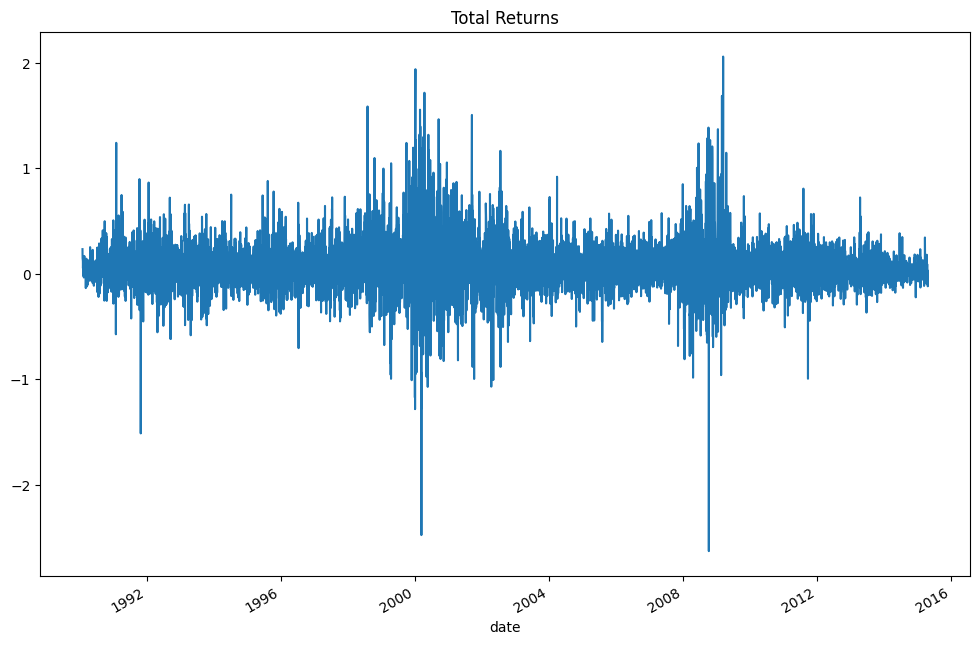

In [18]:
#plot total returns
total_returns.plot(figsize=(12,8), title='Total Returns')

In [19]:

#import plotly express
import plotly.express as px
# Grouping by year and calculating the mean daily return for each year
year_returns = total_returns.groupby(total_returns.index.year).mean()

# Converting the series to DataFrame and resetting the index for plotting
year_returns = year_returns.to_frame().reset_index()

# Renaming the columns
year_returns.columns = ['Year', 'Returns']

# Converting the returns to percentage and rounding off
year_returns['Returns'] = (year_returns['Returns'] )

# Plotting the average daily returns per year
fig = px.bar(year_returns, x='Year', y='Returns', title='Average Daily Returns by Year')

# Showing the plot
fig.show()



Compare 1,0 to model that predicts returns only (can bucket 10 return buckets maybe),peanlize mispredictions of 1 more than 0 Geanie impurity. Change dataset in testing to only consider current sp 500

In [20]:

# Create a DataFrame from the Series to make grouping easier
sharpe_df = pd.DataFrame(total_returns)
sharpe_df.columns = ['RET']
sharpe_df['Year'] = sharpe_df.index.year

# Group by year and calculate the Sharpe ratio for each year
sharpe_ratios = sharpe_df.groupby('Year')['RET'].apply(calculate_sharpe_ratio)

# Calculate the annualized Sharpe ratio for each year
annualized_sharpe_ratios = sharpe_ratios.apply(calculate_annualized_sharpe_ratio)

# Create a DataFrame to store the annualized Sharpe ratios
annualized_sharpe_ratio_df = pd.DataFrame(annualized_sharpe_ratios).reset_index()
annualized_sharpe_ratio_df.columns = ['Year', 'Annualized Sharpe Ratio']

# Create a bar plot of the annualized Sharpe ratios
fig = px.bar(annualized_sharpe_ratio_df, x='Year', y='Annualized Sharpe Ratio',
             title='Annualized Sharpe Ratio by Year',
             labels={'Annualized Sharpe Ratio': 'Annualized Sharpe Ratio'})

# Show the plot
fig.show()









In [21]:
from scipy.stats import ttest_1samp
import numpy as np

# Assume returns is a numpy array containing your strategy's returns
t_stat, p_value = ttest_1samp(total_returns, 0)
print(f"P-Value: {p_value}")
print(f"T-Statistic: {t_stat}")

P-Value: 1.0955857059554113e-246
T-Statistic: 34.34335052151305


In [22]:
from collections import Counter
import pandas as pd
import plotly.express as px

# Assume these are your actual dataframes and 'Ticker' is the column with the ticker names.
# If not, adjust the column name accordingly.
long_counts = Counter(in_sample_long_portfolios['TICKER'])
short_counts = Counter(in_sample_short_portfolios['TICKER'])

# Get the unique tickers from both portfolios
all_tickers = set(long_counts.keys()) | set(short_counts.keys())

# Prepare data for the plot
plot_data = pd.DataFrame(columns=['Ticker', 'Long', 'Short'])

for ticker in all_tickers:
    long_count = long_counts.get(ticker, 0)
    short_count = short_counts.get(ticker, 0)
    plot_data = plot_data.append({'Ticker': ticker, 'Long': long_count, 'Short': short_count}, ignore_index=True)

# Create the plot
fig = px.scatter(plot_data, x='Long', y='Short', hover_name='Ticker',
                 labels={'Long': 'Times Long', 'Short': 'Times Short'},
                 title='Long vs Short Occurrences for Each Ticker',
                 size_max=60)

# Update the layout to show the text labels
fig.update_traces(textposition='top center')
fig.update_layout(showlegend=False)
fig.show()



Ideas:
Color this plot by volatility of returns for each equity

In [23]:
volatiliy_df=df[['date','TICKER','RET']]
#group by equity and calculate the daily average std dev of returns 
volatiliy_df=volatiliy_df.groupby('TICKER')['RET'].std()
volatiliy_df

TICKER
A       0.029940
AA      0.024053
AAL     0.023424
AAP     0.023584
AAPL    0.028392
          ...   
Z       0.019850
ZBH     0.013591
ZION    0.017376
ZMH     0.017582
ZTS     0.015519
Name: RET, Length: 1973, dtype: float64

In [24]:

# Merging the std_dev_data with plot_data on the 'Ticker' column
plot_data['std_dev'] = plot_data['Ticker'].map(volatiliy_df)

# Handling cases where there might be NaN values after the merge
plot_data['std_dev'].fillna(plot_data['std_dev'].mean(), inplace=True)  # Filling NaN with mean std_dev, you can choose another method if preferred


In [25]:
plot_data

,Ticker,Long,Short,std_dev
0,RSP,2,0,0.019830
1,WAG,39,221,0.017815
2,CIR,94,40,0.023178
3,FC,1,10,0.015944
4,BVF,42,0,0.032835
...,...,...,...,...
1402,RCL,194,169,0.025667
1403,MACR,0,1,0.075442
1404,XLA,0,4,0.100075
1405,ABI,22,7,0.038435


In [26]:
plot_data['Total_Trade'] = plot_data['Long'] + plot_data['Short']

# Plot
fig = px.scatter(plot_data, x='Total_Trade', y='std_dev', hover_name='Ticker',
                 labels={'Total_Trade': 'Total Time Traded', 'std_dev': 'Std Dev of Returns'},
                 title='Standard Deviation of Returns vs Total Time Traded',
                 size_max=60, opacity=0.7)

fig.update_layout(showlegend=False)
fig.show()


# Bucketing Approach

In [31]:
df

,date,TICKER,RET
0,1990-01-02,SUNW,0.043478
1,1990-01-03,SUNW,0.000000
2,1990-01-04,SUNW,-0.013889
3,1990-01-05,SUNW,0.000000
4,1990-01-08,SUNW,0.007042
...,...,...,...
3286620,2015-12-24,TSLA,0.003788
3286621,2015-12-28,TSLA,-0.007026
3286622,2015-12-29,TSLA,0.035990
3286623,2015-12-30,TSLA,0.003794


In [32]:
#standerdize returns
import pandas as pd
from tqdm import tqdm

# Sample data loading. Adjust this according to your actual data
# df = pd.read_csv('your_data.csv')
# Ensure 'date' column is datetime
# df['date'] = pd.to_datetime(df['date'])

# Setting the initial start date and end date
start_date = pd.Timestamp('1990-01-01')
end_date = pd.Timestamp('2015-12-31')

study_periods = []
window_size = 240  # Adjust the window size as needed

# Iterate through the DataFrame with a step size of 250 days (the length of the trading period)
for start in tqdm(pd.date_range(start=start_date, end=end_date, freq='250D')):
    train_start = start
    train_end = start + pd.DateOffset(days=750)
    trade_end = train_end + pd.DateOffset(days=250)
    
    if trade_end > end_date:
        print("Reached the end of the dataset.")
        break

    # Create separate DataFrames for training and trading periods
    train_df = df[(df['date'] >= train_start) & (df['date'] < train_end)].copy()
    trade_df = df[(df['date'] >= train_end) & (df['date'] < trade_end)].copy()
    
    if train_df.empty:
        print(f"No data available from {train_start.date()} to {train_end.date()}. Skipping.")
        continue

    # Standardize returns with a rolling window
    train_df['rolling_mean'] = train_df.groupby('TICKER')['RET'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    mu = train_df['rolling_mean'].mean()
    sigma = train_df['rolling_mean'].std()
    train_df['standardized_return'] = (train_df['rolling_mean'] - mu) / sigma

    # Standardize returns for trade_df using the mean and std dev from train_df
    trade_df['rolling_mean'] = trade_df.groupby('TICKER')['RET'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    trade_df['standardized_return'] = (trade_df['rolling_mean'] - mu) / sigma
    
    #Make 10 buckets of returns as targets
    train_df['ret_buckets']= train_df.groupby('TICKER')['standardized_return'].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

    trade_df['ret_buckets']= trade_df.groupby('TICKER')['standardized_return'].transform(
    lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

    # Store the training and trading DataFrames in the study_periods list
    study_periods.append((train_df, trade_df))

    print(f"Period: Training {train_start.date()} to {train_end.date()}, Trading {train_end.date()} to {trade_end.date()}")

  0%|          | 0/38 [00:00<?, ?it/s]

  3%|▎         | 1/38 [00:01<00:43,  1.18s/it]

Period: Training 1990-01-01 to 1992-01-21, Trading 1992-01-21 to 1992-09-27


  5%|▌         | 2/38 [00:01<00:33,  1.07it/s]

Period: Training 1990-09-08 to 1992-09-27, Trading 1992-09-27 to 1993-06-04


  8%|▊         | 3/38 [00:02<00:30,  1.16it/s]

Period: Training 1991-05-16 to 1993-06-04, Trading 1993-06-04 to 1994-02-09


 11%|█         | 4/38 [00:03<00:28,  1.18it/s]

Period: Training 1992-01-21 to 1994-02-09, Trading 1994-02-09 to 1994-10-17


 13%|█▎        | 5/38 [00:04<00:26,  1.23it/s]

Period: Training 1992-09-27 to 1994-10-17, Trading 1994-10-17 to 1995-06-24


 16%|█▌        | 6/38 [00:05<00:26,  1.22it/s]

Period: Training 1993-06-04 to 1995-06-24, Trading 1995-06-24 to 1996-02-29


 18%|█▊        | 7/38 [00:05<00:25,  1.24it/s]

Period: Training 1994-02-09 to 1996-02-29, Trading 1996-02-29 to 1996-11-05


 21%|██        | 8/38 [00:06<00:23,  1.25it/s]

Period: Training 1994-10-17 to 1996-11-05, Trading 1996-11-05 to 1997-07-13


 24%|██▎       | 9/38 [00:07<00:24,  1.21it/s]

Period: Training 1995-06-24 to 1997-07-13, Trading 1997-07-13 to 1998-03-20


 26%|██▋       | 10/38 [00:08<00:22,  1.22it/s]

Period: Training 1996-02-29 to 1998-03-20, Trading 1998-03-20 to 1998-11-25


 29%|██▉       | 11/38 [00:09<00:22,  1.19it/s]

Period: Training 1996-11-05 to 1998-11-25, Trading 1998-11-25 to 1999-08-02


 32%|███▏      | 12/38 [00:10<00:22,  1.18it/s]

Period: Training 1997-07-13 to 1999-08-02, Trading 1999-08-02 to 2000-04-08


 34%|███▍      | 13/38 [00:11<00:21,  1.14it/s]

Period: Training 1998-03-20 to 2000-04-08, Trading 2000-04-08 to 2000-12-14


 37%|███▋      | 14/38 [00:11<00:21,  1.14it/s]

Period: Training 1998-11-25 to 2000-12-14, Trading 2000-12-14 to 2001-08-21


 39%|███▉      | 15/38 [00:12<00:20,  1.15it/s]

Period: Training 1999-08-02 to 2001-08-21, Trading 2001-08-21 to 2002-04-28


 42%|████▏     | 16/38 [00:13<00:19,  1.13it/s]

Period: Training 2000-04-08 to 2002-04-28, Trading 2002-04-28 to 2003-01-03


 45%|████▍     | 17/38 [00:14<00:17,  1.17it/s]

Period: Training 2000-12-14 to 2003-01-03, Trading 2003-01-03 to 2003-09-10


 47%|████▋     | 18/38 [00:15<00:16,  1.19it/s]

Period: Training 2001-08-21 to 2003-09-10, Trading 2003-09-10 to 2004-05-17


 50%|█████     | 19/38 [00:16<00:16,  1.18it/s]

Period: Training 2002-04-28 to 2004-05-17, Trading 2004-05-17 to 2005-01-22


 53%|█████▎    | 20/38 [00:17<00:15,  1.16it/s]

Period: Training 2003-01-03 to 2005-01-22, Trading 2005-01-22 to 2005-09-29


 55%|█████▌    | 21/38 [00:17<00:14,  1.20it/s]

Period: Training 2003-09-10 to 2005-09-29, Trading 2005-09-29 to 2006-06-06


 58%|█████▊    | 22/38 [00:18<00:13,  1.21it/s]

Period: Training 2004-05-17 to 2006-06-06, Trading 2006-06-06 to 2007-02-11


 61%|██████    | 23/38 [00:19<00:12,  1.21it/s]

Period: Training 2005-01-22 to 2007-02-11, Trading 2007-02-11 to 2007-10-19


 63%|██████▎   | 24/38 [00:20<00:11,  1.25it/s]

Period: Training 2005-09-29 to 2007-10-19, Trading 2007-10-19 to 2008-06-25


 66%|██████▌   | 25/38 [00:21<00:10,  1.22it/s]

Period: Training 2006-06-06 to 2008-06-25, Trading 2008-06-25 to 2009-03-02


 68%|██████▊   | 26/38 [00:22<00:10,  1.10it/s]

Period: Training 2007-02-11 to 2009-03-02, Trading 2009-03-02 to 2009-11-07


 71%|███████   | 27/38 [00:22<00:09,  1.15it/s]

Period: Training 2007-10-19 to 2009-11-07, Trading 2009-11-07 to 2010-07-15


 74%|███████▎  | 28/38 [00:23<00:08,  1.15it/s]

Period: Training 2008-06-25 to 2010-07-15, Trading 2010-07-15 to 2011-03-22


 76%|███████▋  | 29/38 [00:24<00:07,  1.20it/s]

Period: Training 2009-03-02 to 2011-03-22, Trading 2011-03-22 to 2011-11-27


 79%|███████▉  | 30/38 [00:25<00:06,  1.24it/s]

Period: Training 2009-11-07 to 2011-11-27, Trading 2011-11-27 to 2012-08-03


 82%|████████▏ | 31/38 [00:26<00:05,  1.26it/s]

Period: Training 2010-07-15 to 2012-08-03, Trading 2012-08-03 to 2013-04-10


 84%|████████▍ | 32/38 [00:26<00:04,  1.23it/s]

Period: Training 2011-03-22 to 2013-04-10, Trading 2013-04-10 to 2013-12-16


 87%|████████▋ | 33/38 [00:27<00:03,  1.27it/s]

Period: Training 2011-11-27 to 2013-12-16, Trading 2013-12-16 to 2014-08-23


 89%|████████▉ | 34/38 [00:28<00:03,  1.19it/s]

Period: Training 2012-08-03 to 2014-08-23, Trading 2014-08-23 to 2015-04-30
Reached the end of the dataset.


In [33]:
study_periods[1][1]

,date,TICKER,RET,rolling_mean,standardized_return,ret_buckets
693,1992-09-28,SUNW,0.000000,0.000000,-0.336603,2
694,1992-09-29,SUNW,0.024390,0.012195,3.776306,9
695,1992-09-30,SUNW,-0.007937,0.005484,1.513054,9
696,1992-10-01,SUNW,-0.088000,-0.017887,-6.369121,0
697,1992-10-02,SUNW,0.017544,-0.010801,-3.979233,0
...,...,...,...,...,...,...
3267409,1993-05-27,UNH,0.010417,0.001894,0.302078,4
3267410,1993-05-28,UNH,-0.014433,0.001798,0.269687,4
3267411,1993-06-01,UNH,-0.004184,0.001763,0.257889,3
3267412,1993-06-02,UNH,-0.021008,0.001630,0.213240,3


In [34]:
#drop rows in na ret_buckets
for period in study_periods:
    period[0].dropna(subset=['ret_buckets'],inplace=True)
    period[1].dropna(subset=['ret_buckets'],inplace=True)

In [36]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=20, random_state=42)

In [37]:
# Creating separate DataFrames for in-sample and out-of-sample portfolios
in_sample_long_portfolios = pd.DataFrame()
out_of_sample_long_portfolios = pd.DataFrame()

in_sample_short_portfolios = pd.DataFrame()
out_of_sample_short_portfolios = pd.DataFrame()

for train_df, test_df in tqdm(study_periods):
    X_train = train_df[['standardized_return']]
    y_train = train_df['ret_buckets']

    X_test = test_df[['standardized_return']]
    y_test = test_df['ret_buckets']

    clf = RandomForestClassifier(n_estimators=1000, max_depth=20, random_state=42)

    # Train the classifier
    clf.fit(X_train, y_train)

    # Predict on both train and test data
    train_preds = clf.predict(X_train)
    test_preds = clf.predict(X_test)

    # Assign predicted buckets back to train and test dataframes
    train_df['predicted_bucket'] = train_preds
    test_df['predicted_bucket'] = test_preds

    k = 10

    # Iterate over unique dates in train_df for in-sample data
    for date in train_df['date'].unique():
        date_data = train_df[train_df['date'] == date]

        # Select the top k stocks with the highest predicted bucket (return)
        long_tickers = date_data.nlargest(k, 'predicted_bucket')[['date', 'TICKER', 'predicted_bucket']]
        # Select the bottom k stocks with the lowest predicted bucket (return)
        short_tickers = date_data.nsmallest(k, 'predicted_bucket')[['date', 'TICKER', 'predicted_bucket']]

        in_sample_long_portfolios = pd.concat([in_sample_long_portfolios, long_tickers])
        in_sample_short_portfolios = pd.concat([in_sample_short_portfolios, short_tickers])

    # Iterate over unique dates in test_df for out-of-sample data
    for date in test_df['date'].unique():
        date_data = test_df[test_df['date'] == date]

        #WE BREAK TIES ARBITRARILY, ways to break ties could be market cap, (previous n day returns), volatility, etc.
        # Select the top k stocks with the highest predicted bucket (return)
        long_tickers = date_data.nlargest(k, 'predicted_bucket')[['date', 'TICKER', 'predicted_bucket']]
        # Select the bottom k stocks with the lowest predicted bucket (return)
        short_tickers = date_data.nsmallest(k, 'predicted_bucket')[['date', 'TICKER', 'predicted_bucket']]

        out_of_sample_long_portfolios = pd.concat([out_of_sample_long_portfolios, long_tickers])
        out_of_sample_short_portfolios = pd.concat([out_of_sample_short_portfolios, short_tickers])


  0%|          | 0/34 [00:00<?, ?it/s]

100%|██████████| 34/34 [4:23:30<00:00, 465.03s/it]  


In [38]:
from math import sqrt

# Function to calculate portfolio returns
def calculate_portfolio_returns(portfolios, returns_df):
    merged_df = portfolios.merge(returns_df, on=['date', 'TICKER'])
    
    # Debugging print to check the merged DataFrame
    print(merged_df.head())
    
    portfolio_returns = merged_df['RET'].groupby(merged_df['date']).sum()
    
    # Debugging print to check the portfolio returns
    print(portfolio_returns.head())
    
    return portfolio_returns


# Function to calculate Sharpe ratio
def calculate_sharpe_ratio(returns, rf=0.0004):
    expected_return = returns.mean()
    std_dev = returns.std()
    sharpe_ratio = (expected_return - rf) / std_dev if std_dev != 0 else 0  # Added a condition to avoid division by zero
    return sharpe_ratio

def calculate_annualized_sharpe_ratio(sharpe_ratio, periods_per_year=252):
    annualized_sharpe_ratio = sharpe_ratio * sqrt(periods_per_year)
    return annualized_sharpe_ratio


# Calculate in-sample and out-of-sample returns for long and short portfolios
in_sample_long_returns = calculate_portfolio_returns(in_sample_long_portfolios, returns_df)
out_of_sample_long_returns = calculate_portfolio_returns(out_of_sample_long_portfolios, returns_df)

in_sample_short_returns = -calculate_portfolio_returns(in_sample_short_portfolios, returns_df)
out_of_sample_short_returns = -calculate_portfolio_returns(out_of_sample_short_portfolios, returns_df)

# Calculate total returns (long + short)
in_sample_total_returns = in_sample_long_returns + in_sample_short_returns
out_of_sample_total_returns = out_of_sample_long_returns + out_of_sample_short_returns

# Calculate Sharpe ratios
in_sample_sharpe = calculate_sharpe_ratio(in_sample_total_returns)
out_of_sample_sharpe = calculate_sharpe_ratio(out_of_sample_total_returns)



# Calculate annualized Sharpe ratios
in_sample_annualized_sharpe = calculate_annualized_sharpe_ratio(in_sample_sharpe)
out_of_sample_annualized_sharpe = calculate_annualized_sharpe_ratio(out_of_sample_sharpe)
print(f"In-Sample Annualized Sharpe Ratio: {in_sample_annualized_sharpe}")
print(f"Out-Of-Sample Annualized Sharpe Ratio: {out_of_sample_annualized_sharpe}")

        date TICKER  predicted_bucket       RET
0 1990-01-02   SUNW               9.0  0.043478
1 1990-01-02   ORCL               9.0  0.032086
2 1990-01-02   MSFT               9.0  0.020115
3 1990-01-02    AYP               9.0  0.002985
4 1990-01-02    ALD               9.0  0.014337
date
1990-01-02    0.217924
1990-01-03    0.142693
1990-01-04    0.079533
1990-01-05   -0.019901
1990-01-08    0.034292
Name: RET, dtype: float64
        date TICKER  predicted_bucket       RET
0 1992-01-21    AYP               9.0  0.011765
1 1992-01-21    ALD               9.0  0.005391
2 1992-01-21    AMB               9.0  0.002762
3 1992-01-21    ARC               9.0  0.015784
4 1992-01-21     KO               9.0  0.010327
date
1992-01-21    0.088763
1992-01-22    0.441353
1992-01-23    0.006970
1992-01-24    0.115178
1992-01-27    0.180161
Name: RET, dtype: float64
        date TICKER  predicted_bucket       RET
0 1990-01-02    ADM               0.0 -0.005405
1 1990-01-02    CPC               0.

In [39]:
#calculate the oos mean returns
in_sample_mean_returns=in_sample_total_returns.mean()
out_of_sample_mean_returns=out_of_sample_total_returns.mean()
print(in_sample_mean_returns)
print(out_of_sample_mean_returns)

0.17879943100949927
0.06395638120416168


# TODO: Sensitivity analysis to different amount of buckets

In [40]:
df

,date,TICKER,RET
0,1990-01-02,SUNW,0.043478
1,1990-01-03,SUNW,0.000000
2,1990-01-04,SUNW,-0.013889
3,1990-01-05,SUNW,0.000000
4,1990-01-08,SUNW,0.007042
...,...,...,...
3286620,2015-12-24,TSLA,0.003788
3286621,2015-12-28,TSLA,-0.007026
3286622,2015-12-29,TSLA,0.035990
3286623,2015-12-30,TSLA,0.003794


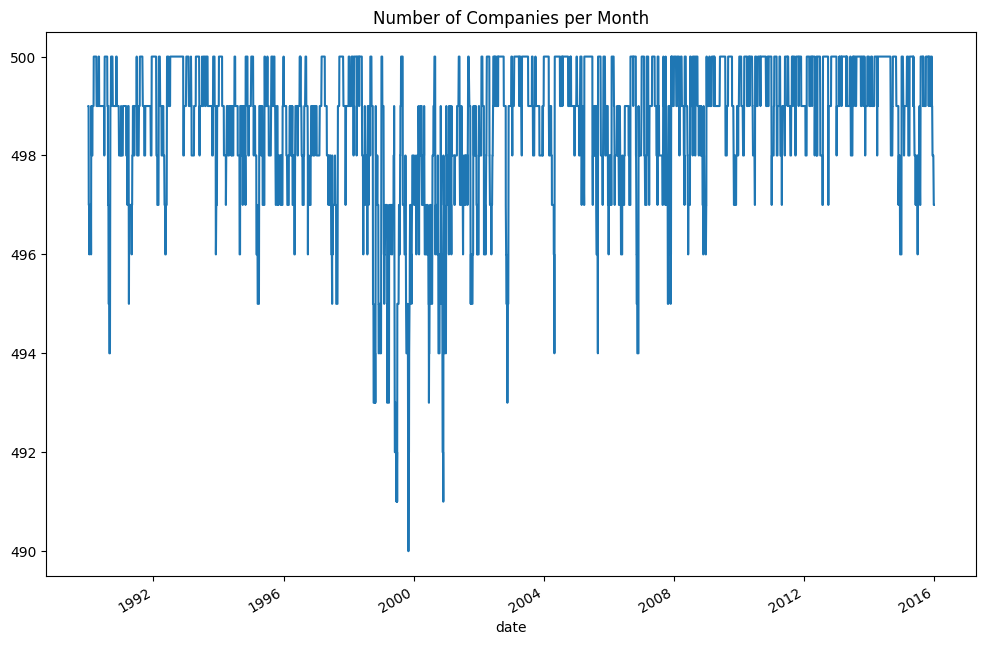

In [41]:
#output companies per month
companies_per_month=df.groupby('date')['TICKER'].nunique()
#plot
companies_per_month.plot(figsize=(12,8), title='Number of Companies per Month')
plt.show()

In [42]:
#When does TSLA 1st appear in the dataset?
df[df['TICKER'] == 'TSLA']['date'].min()

Timestamp('2013-05-01 00:00:00')

TSLA was 20 billion around this date, so while it wasn't in the S&P, it was likely a top 500 company in terms of market cap

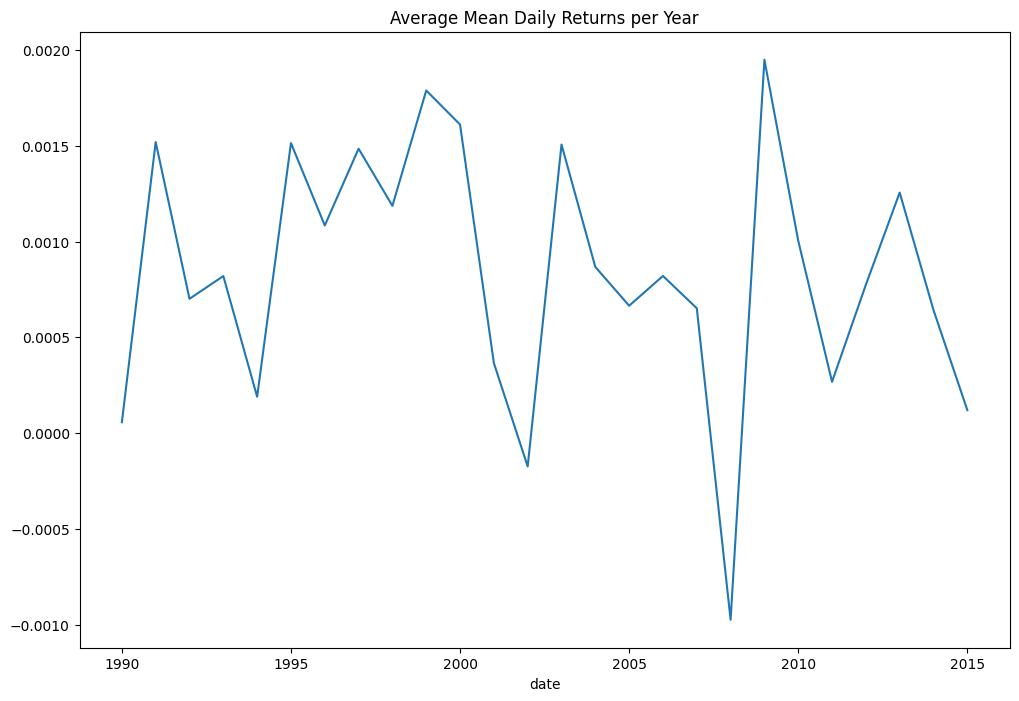

In [43]:
#plot average mean daily returns per year
year_returns = df.groupby(df['date'].dt.year)['RET'].mean()
year_returns.plot(figsize=(12,8), title='Average Mean Daily Returns per Year')
plt.show()

# Raw Returns

In [27]:
#standerdize returns
import pandas as pd
from tqdm import tqdm

# Sample data loading. Adjust this according to your actual data
# df = pd.read_csv('your_data.csv')
# Ensure 'date' column is datetime
# df['date'] = pd.to_datetime(df['date'])

# Setting the initial start date and end date
start_date = pd.Timestamp('1990-01-01')
end_date = pd.Timestamp('2015-12-31')

study_periods = []
window_size = 240  # Adjust the window size as needed

# Iterate through the DataFrame with a step size of 250 days (the length of the trading period)
for start in tqdm(pd.date_range(start=start_date, end=end_date, freq='250D')):
    train_start = start
    train_end = start + pd.DateOffset(days=750)
    trade_end = train_end + pd.DateOffset(days=250)
    
    if trade_end > end_date:
        print("Reached the end of the dataset.")
        break

    # Create separate DataFrames for training and trading periods
    train_df = df[(df['date'] >= train_start) & (df['date'] < train_end)].copy()
    trade_df = df[(df['date'] >= train_end) & (df['date'] < trade_end)].copy()
    
    if train_df.empty:
        print(f"No data available from {train_start.date()} to {train_end.date()}. Skipping.")
        continue

    # Standardize returns with a rolling window
    train_df['rolling_mean'] = train_df.groupby('TICKER')['RET'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    mu = train_df['rolling_mean'].mean()
    sigma = train_df['rolling_mean'].std()
    train_df['standardized_return'] = (train_df['rolling_mean'] - mu) / sigma

    # Standardize returns for trade_df using the mean and std dev from train_df
    trade_df['rolling_mean'] = trade_df.groupby('TICKER')['RET'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    trade_df['standardized_return'] = (trade_df['rolling_mean'] - mu) / sigma
    

    # Store the training and trading DataFrames in the study_periods list
    study_periods.append((train_df, trade_df))

    # print(f"Period: Training {train_start.date()} to {train_end.date()}, Trading {train_end.date()} to {trade_end.date()}")

 89%|████████▉ | 34/38 [00:09<00:01,  3.62it/s]

Reached the end of the dataset.


In [28]:
study_periods[1][1]

,date,TICKER,RET,rolling_mean,standardized_return
671,1992-09-28,SUNW,0.000000,0.000000,-0.240896
672,1992-09-29,SUNW,0.024390,0.012195,4.052988
673,1992-09-30,SUNW,-0.007937,0.005484,1.690149
674,1992-10-01,SUNW,-0.088000,-0.017887,-6.538857
675,1992-10-02,SUNW,0.017544,-0.010801,-4.043809
...,...,...,...,...,...
3247799,1993-05-27,UNH,0.010417,0.001894,0.425887
3247800,1993-05-28,UNH,-0.014433,0.001798,0.392072
3247801,1993-06-01,UNH,-0.004184,0.001763,0.379755
3247802,1993-06-02,UNH,-0.021008,0.001630,0.333141


In [29]:
import pandas as pd
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Creating separate DataFrames for in-sample and out-of-sample portfolios
in_sample_long_portfolios = pd.DataFrame()
out_of_sample_long_portfolios = pd.DataFrame()

in_sample_short_portfolios = pd.DataFrame()
out_of_sample_short_portfolios = pd.DataFrame()

# Assuming study_periods contains the train-test split dataframes
for train_df, test_df in tqdm(study_periods):
    X_train = train_df[['standardized_return']]
    y_train = train_df['RET']  # Change to 'RET' to predict actual returns

    X_test = test_df[['standardized_return']]
    y_test = test_df['RET']  # Change to 'RET' to predict actual returns

    regr = RandomForestRegressor(n_estimators=1000, max_depth=20, random_state=42)

    # Train the regressor
    regr.fit(X_train, y_train)

    # Predict on both train and test data
    train_preds = regr.predict(X_train)
    test_preds = regr.predict(X_test)

    # Assign predicted returns back to train and test dataframes
    train_df['predicted_return'] = train_preds
    test_df['predicted_return'] = test_preds

    k = 10  # Number of positions to take for both long and short portfolios

    # Iterate over unique dates in train_df for in-sample data
    for date in train_df['date'].unique():
        date_data = train_df[train_df['date'] == date]

        # Select the top k stocks with the highest predicted return
        long_tickers = date_data.nlargest(k, 'predicted_return')[['date', 'TICKER', 'predicted_return']]
        # Select the bottom k stocks with the lowest predicted return
        short_tickers = date_data.nsmallest(k, 'predicted_return')[['date', 'TICKER', 'predicted_return']]

        in_sample_long_portfolios = pd.concat([in_sample_long_portfolios, long_tickers])
        in_sample_short_portfolios = pd.concat([in_sample_short_portfolios, short_tickers])

    # Iterate over unique dates in test_df for out-of-sample data
    for date in test_df['date'].unique():
        date_data = test_df[test_df['date'] == date]

        # Select the top k stocks with the highest predicted return
        long_tickers = date_data.nlargest(k, 'predicted_return')[['date', 'TICKER', 'predicted_return']]
        # Select the bottom k stocks with the lowest predicted return
        short_tickers = date_data.nsmallest(k, 'predicted_return')[['date', 'TICKER', 'predicted_return']]

        out_of_sample_long_portfolios = pd.concat([out_of_sample_long_portfolios, long_tickers])
        out_of_sample_short_portfolios = pd.concat([out_of_sample_short_portfolios, short_tickers])


100%|██████████| 34/34 [5:27:06<00:00, 577.25s/it]   


In [30]:
returns_df=df[['date','TICKER','RET']]
returns_df

,date,TICKER,RET
0,1990-02-01,SUNW,0.012903
1,1990-02-02,SUNW,-0.012739
2,1990-02-05,SUNW,0.012903
3,1990-02-06,SUNW,0.031847
4,1990-02-07,SUNW,0.074074
...,...,...,...
3266862,2015-12-24,TSLA,0.003788
3266863,2015-12-28,TSLA,-0.007026
3266864,2015-12-29,TSLA,0.035990
3266865,2015-12-30,TSLA,0.003794


In [31]:
from math import sqrt

# Function to calculate portfolio returns
def calculate_portfolio_returns(portfolios, returns_df):
    merged_df = portfolios.merge(returns_df, on=['date', 'TICKER'])
    
    # Debugging print to check the merged DataFrame
    print(merged_df.head())
    
    portfolio_returns = merged_df['RET'].groupby(merged_df['date']).sum()
    
    # Debugging print to check the portfolio returns
    print(portfolio_returns.head())
    
    return portfolio_returns


# Function to calculate Sharpe ratio
def calculate_sharpe_ratio(returns, rf=0.0004):
    expected_return = returns.mean()
    std_dev = returns.std()
    sharpe_ratio = (expected_return - rf) / std_dev if std_dev != 0 else 0  # Added a condition to avoid division by zero
    return sharpe_ratio

def calculate_annualized_sharpe_ratio(sharpe_ratio, periods_per_year=252):
    annualized_sharpe_ratio = sharpe_ratio * sqrt(periods_per_year)
    return annualized_sharpe_ratio


# Calculate in-sample and out-of-sample returns for long and short portfolios
in_sample_long_returns = calculate_portfolio_returns(in_sample_long_portfolios, returns_df)
out_of_sample_long_returns = calculate_portfolio_returns(out_of_sample_long_portfolios, returns_df)

in_sample_short_returns = -calculate_portfolio_returns(in_sample_short_portfolios, returns_df)
out_of_sample_short_returns = -calculate_portfolio_returns(out_of_sample_short_portfolios, returns_df)

# Calculate total returns (long + short)
in_sample_total_returns = in_sample_long_returns + in_sample_short_returns
out_of_sample_total_returns = out_of_sample_long_returns + out_of_sample_short_returns

# Calculate Sharpe ratios
in_sample_sharpe = calculate_sharpe_ratio(in_sample_total_returns)
out_of_sample_sharpe = calculate_sharpe_ratio(out_of_sample_total_returns)



# Calculate annualized Sharpe ratios
in_sample_annualized_sharpe = calculate_annualized_sharpe_ratio(in_sample_sharpe)
out_of_sample_annualized_sharpe = calculate_annualized_sharpe_ratio(out_of_sample_sharpe)
print(f"In-Sample Annualized Sharpe Ratio: {in_sample_annualized_sharpe}")
print(f"Out-Of-Sample Annualized Sharpe Ratio: {out_of_sample_annualized_sharpe}")

        date TICKER  predicted_return       RET
0 1990-02-01    GPS          0.052174  0.064171
1 1990-02-01    UTH          0.038463  0.028169
2 1990-02-01    HRB          0.038299  0.040441
3 1990-02-01    LTD          0.037911  0.045627
4 1990-02-01    GRA          0.037432  0.038793
date
1990-02-01    0.422648
1990-02-02    0.888317
1990-02-05    0.482505
1990-02-06    0.217172
1990-02-07    0.566204
Name: RET, dtype: float64
        date TICKER  predicted_return       RET
0 1992-01-21     VO          0.073687 -0.010331
1 1992-01-21    SRR          0.055526  0.048246
2 1992-01-21    BLS          0.043139  0.017632
3 1992-01-21    AHC          0.040590  0.032086
4 1992-01-21     UT          0.037475  0.025907
date
1992-01-21    0.255729
1992-01-22    0.462302
1992-01-23    0.249238
1992-01-24   -0.044113
1992-01-27    0.075977
Name: RET, dtype: float64
        date TICKER  predicted_return       RET
0 1990-02-01    MES         -0.093473 -0.024862
1 1990-02-01    CLT         -0.06165

In [32]:
#mean returns
in_sample_mean_returns=in_sample_total_returns.mean()
out_of_sample_mean_returns=out_of_sample_total_returns.mean()
print(in_sample_mean_returns)
print(out_of_sample_mean_returns)

1.827890230085636
0.10282642572062085


In [34]:
# standard deviation
in_sample_std_returns=in_sample_total_returns.std()
out_of_sample_std_returns=out_of_sample_total_returns.std()
print(in_sample_std_returns)
print(out_of_sample_std_returns)

1.206580530449111
0.22681080073130078


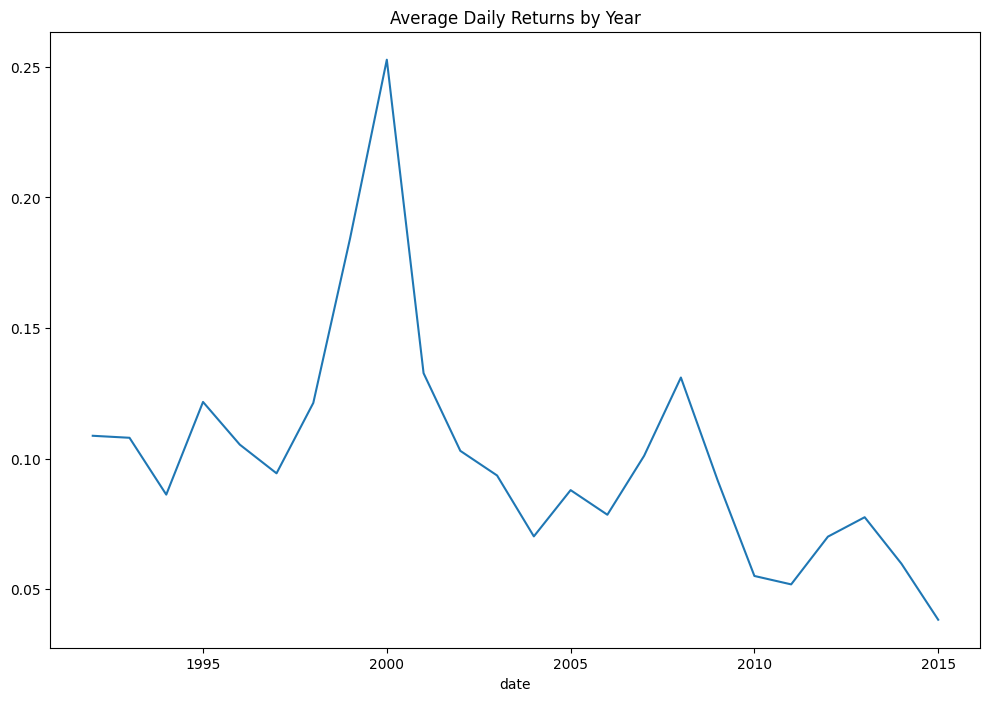

In [33]:
#plot the average daily return per year oos
year_returns = out_of_sample_total_returns.groupby(out_of_sample_total_returns.index.year).mean()
year_returns.plot(figsize=(12,8), title='Average Daily Returns by Year')
plt.show()

In [48]:
out_of_sample_long_returns

date
2009-01-02    0.401360
2009-01-05    0.095692
2009-01-06    0.047954
2009-01-07   -0.191319
2009-01-08    0.083122
                ...   
2015-04-23    0.079564
2015-04-24    0.024973
2015-04-27    0.026830
2015-04-28    0.015005
2015-04-29   -0.088517
Name: RET, Length: 1591, dtype: float64